# Denoising and contractive autoencoder - MINST Experiment

# Code

## Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

## Load dataset

In [ ]:
def load_data():
    # Load the MNIST dataset, ignoring the labels
    (x_train, _), (x_test, _) = mnist.load_data()
    # Convert the pixel values from integers to floats and normalize them to the range [0, 1].
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    # Reshape the training and testing data to include a channel dimension
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
    return x_train, x_test

## Random noise

In [ ]:
def generate_random_noise(batch_size=10):
    # Generates random noise from a normal (Gaussian) distribution.
    return np.random.normal(loc=0.5, scale=0.5, size=(batch_size, 28, 28, 1))

def add_noise(x, noise_factor=0.5):
    # Adds noise to the input iamge 'x'.
    noisy_data = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    # Ensures that the noisy data is clipped to stay within the range [0, 1],
    return np.clip(noisy_data, 0., 1.)

##Build denoising autoencoder

In [ ]:
def build_denoising_autoencoder():
    # Define the input layer with 784 features (flattened 28x28 image).
    input_img = Input(shape=(784,))
    # Create a series of Dense layers for the encoding part.
    encoded = Dense(256, activation='relu')(input_img)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    # Create a series of Dense layers for the decoding part.
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    # Define the autoencoder model.
    autoencoder = Model(input_img, decoded)
    # Compile the model with an optimizer and loss function.
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

 ## Contractive loss for contractive autoencoder

In [ ]:
def contractive_loss(model, lambd):
    # Define a custom loss function for contractive autoencoder.
    def loss(y_true, y_pred):
        # Compute the average binary cross-entropy loss between true and predicted values.
        reconstruction_loss = K.mean(K.binary_crossentropy(y_true, y_pred))
        # Initialize contractive loss.
        contractive_loss = 0
        # Iterate over each layer in the model.
        for layer in model.layers:
            # Check if the layer is part of the encoder.
            if 'encoder' in layer.name:
                # Get the weights of the layer.
                weights = layer.trainable_weights[0]
                # Compute the sum of squares of the weights.
                weights_jsqr = K.sum(K.square(weights))
                # Accumulate the contractive loss.
                contractive_loss += weights_jsqr
        # Combine the reconstruction and contractive losses.
        return reconstruction_loss + lambd * contractive_loss
    return loss

## Build contractive autoencoder

In [ ]:
def build_contractive_autoencoder(lambd=1e-8):
    # Define the input layer with a shape suitable for a flattened 28x28 image.
    input_img = Input(shape=(784,))
    # Sequentially add dense layers for the encoding part, with each named to identify as part of the encoder.
    encoded = Dense(256, activation='relu', name='encoder1')(input_img)
    encoded = Dense(128, activation='relu', name='encoder2')(encoded)
    encoded = Dense(64, activation='relu', name='encoder3')(encoded)
    encoded = Dense(32, activation='relu', name='encoder4')(encoded)
    # Sequentially add dense layers for the decoding part.
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    # Construct the autoencoder model mapping inputs to decoded outputs.
    autoencoder = Model(input_img, decoded)
    # Compile the model with an Adam optimizer and a custom contractive loss function.
    autoencoder.compile(optimizer='adam', loss=contractive_loss(autoencoder, lambd))
    return autoencoder

## Training

In [ ]:
def train_model(model, x_train, x_train_noisy, x_test, x_test_noisy, epochs=50):
    # Setup an EarlyStopping callback to halt training when validation loss stops improving.
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model using noisy data as input and clean data as targets.
    # Includes shuffling of data and uses early stopping based on validation loss.
    model.fit(x_train_noisy, x_train,
              epochs=epochs,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_noisy, x_test),
              callbacks=[early_stopping])

## Gradient ascent

In [ ]:
def gradient_ascent_step(model, image, learning_rate=1.0):
    # Create a context for computing gradients.
    with tf.GradientTape() as tape:
        tape.watch(image)
        # Get the model's reconstruction of the image.
        reconstruction = model(image)
        # Calculate the loss as the mean squared error between the original and reconstructed images.
        loss = tf.reduce_mean(tf.square(reconstruction - image))
    # Compute gradients of the loss with respect to the image.
    grads = tape.gradient(loss, image)
    # Adjust the image by gradients scaled by the learning rate.
    new_image = image + learning_rate * grads
    return new_image, loss, grads

def apply_gradient_ascent(model, initial_images, model_type='dae', grad_threshold=0.0177):
    # Initializes the images and initial loss.
    images = initial_images
    old_loss = None
    i=0
    while True:
        i+=1
        # perform a single gradient ascent step, updating the images and returning the new loss and gradients.
        images, loss, grads = gradient_ascent_step(model, images)
        # Checks if the norm (size) of the gradients is below a threshold, indicating convergence.
        if tf.norm(grads) < grad_threshold:
            print(f"[{model_type}] Iteration {i+1}: Converged with Loss = {loss.numpy()} and gradient norm = {tf.norm(grads).numpy()}")
            break
        # Updates the old_loss variable with the current loss.
        old_loss = loss.numpy()
        if (i + 1) % 5 == 0:
            print(f"[{model_type}] Iteration {i+1}: Loss = {loss.numpy()} with gradient norm = {tf.norm(grads).numpy()}")
    #  runs the model on the last updated images to generate the final reconstruction.
    final_reconstruction = model(images)
    return images, final_reconstruction

## Display results function

In [ ]:
def display_images(orig, noise, denoised, title):
    # Get the number of images to display.
    n = len(orig)
    # Create a figure with a specified size.
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display the original images.
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(orig[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the noisy images.
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noise[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the denoised images.
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title)
    plt.show()

## Building models

In [ ]:
x_train, x_test = load_data()
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

dae = build_denoising_autoencoder()
cae = build_contractive_autoencoder()

11490434/11490434 [==============================] - 0s 0us/step


## Denoising autoencoder summary

In [ ]:
dae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

## Contractive autoencoder summary

In [ ]:
cae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder1 (Dense)            (None, 256)               200960    
                                                                 
 encoder2 (Dense)            (None, 128)               32896     
                                                                 
 encoder3 (Dense)            (None, 64)                8256      
                                                                 
 encoder4 (Dense)            (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 128)               8320

## Train denoising autoencoder

In [ ]:
train_model(dae, x_train.reshape(-1, 784), x_train_noisy.reshape(-1, 784), x_test.reshape(-1, 784), x_test_noisy.reshape(-1, 784))

Epoch 1/50
235/235 [==============================] - 11s 39ms/step - loss: 0.2571 - val_loss: 0.2004
Epoch 2/50
235/235 [==============================] - 7s 30ms/step - loss: 0.1787 - val_loss: 0.1669
Epoch 3/50
235/235 [==============================] - 8s 34ms/step - loss: 0.1610 - val_loss: 0.1556
Epoch 4/50
235/235 [==============================] - 7s 32ms/step - loss: 0.1521 - val_loss: 0.1486
Epoch 5/50
235/235 [==============================] - 8s 34ms/step - loss: 0.1450 - val_loss: 0.1429
Epoch 6/50
235/235 [==============================] - 9s 37ms/step - loss: 0.1394 - val_loss: 0.1374
Epoch 7/50
235/235 [==============================] - 7s 28ms/step - loss: 0.1353 - val_loss: 0.1341
Epoch 8/50
235/235 [==============================] - 9s 37ms/step - loss: 0.1321 - val_loss: 0.1313
Epoch 9/50
235/235 [==============================] - 7s 30ms/step - loss: 0.1298 - val_loss: 0.1300
Epoch 10/50
235/235 [==============================] - 8s 36ms/step - loss: 0.1276 - val_l

## Train contractive autoencoder

In [ ]:
train_model(cae, x_train.reshape(-1, 784), x_train_noisy.reshape(-1, 784), x_test.reshape(-1, 784), x_test_noisy.reshape(-1, 784))

Epoch 1/50
235/235 [==============================] - 11s 41ms/step - loss: 0.2652 - val_loss: 0.2152
Epoch 2/50
235/235 [==============================] - 9s 40ms/step - loss: 0.1882 - val_loss: 0.1681
Epoch 3/50
235/235 [==============================] - 8s 32ms/step - loss: 0.1615 - val_loss: 0.1544
Epoch 4/50
235/235 [==============================] - 8s 36ms/step - loss: 0.1516 - val_loss: 0.1477
Epoch 5/50
235/235 [==============================] - 7s 31ms/step - loss: 0.1452 - val_loss: 0.1438
Epoch 6/50
235/235 [==============================] - 9s 37ms/step - loss: 0.1407 - val_loss: 0.1389
Epoch 7/50
235/235 [==============================] - 7s 31ms/step - loss: 0.1369 - val_loss: 0.1360
Epoch 8/50
235/235 [==============================] - 9s 37ms/step - loss: 0.1339 - val_loss: 0.1334
Epoch 9/50
235/235 [==============================] - 7s 30ms/step - loss: 0.1314 - val_loss: 0.1319
Epoch 10/50
235/235 [==============================] - 9s 36ms/step - loss: 0.1292 - val_l

## Adding noise to MINST images

In [ ]:
idxs = np.random.choice(len(x_test), 10, replace=False)
test_images = x_test[idxs]
test_images_noisy = x_test_noisy[idxs]

## Denoising autoencoder prediction - MINST images

1/1 [==============================] - 0s 183ms/step


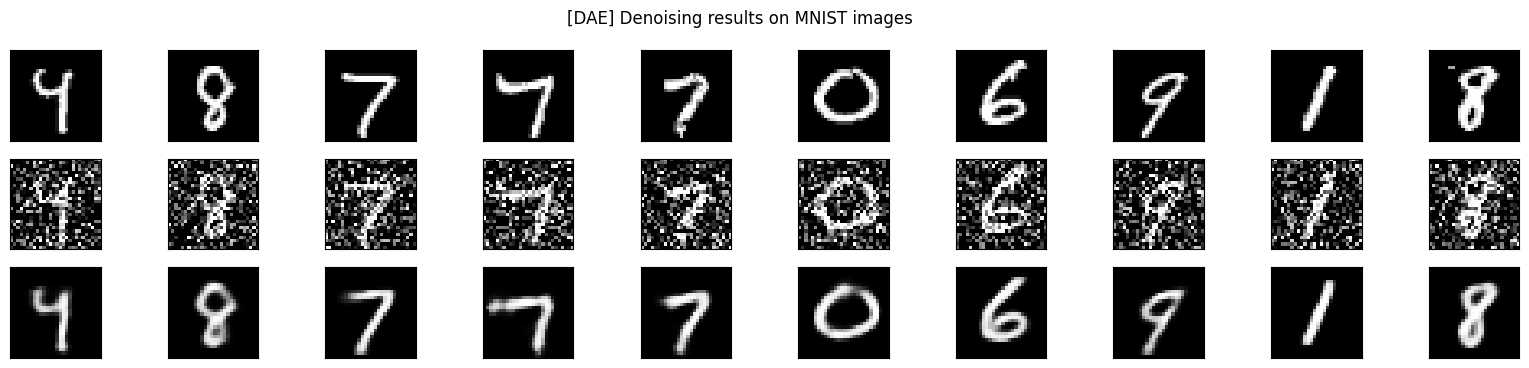

In [ ]:
test_images_denoised = dae.predict(test_images_noisy.reshape(-1, 784)).reshape(-1, 28, 28, 1)
display_images(test_images, test_images_noisy, test_images_denoised, "[DAE] Denoising results on MNIST images")

## Contractive autoencoder prediction - MINST images

1/1 [==============================] - 0s 101ms/step


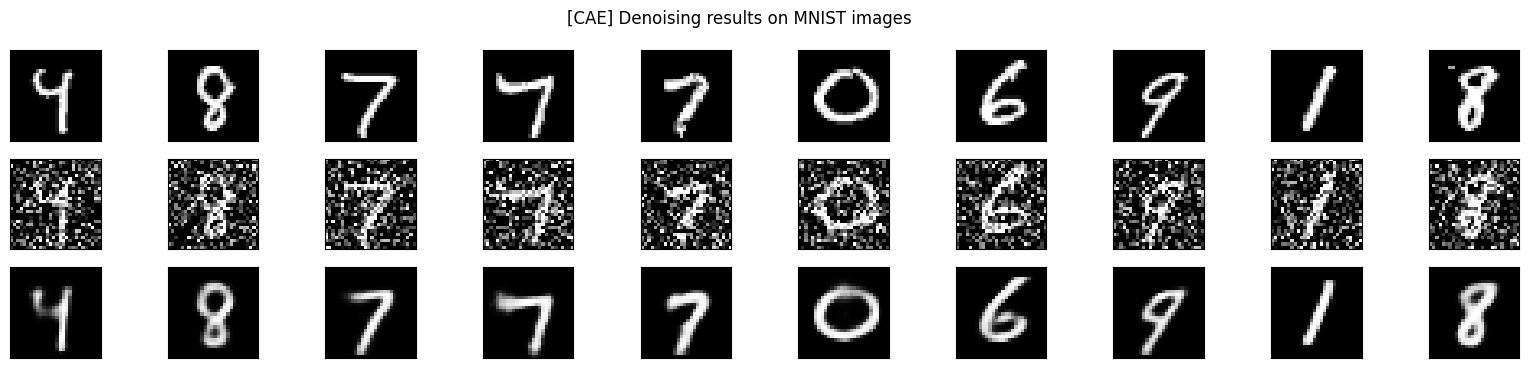

In [ ]:
test_images_denoised_cae = cae.predict(test_images_noisy.reshape(-1, 784)).reshape(-1, 28, 28, 1)
display_images(test_images, test_images_noisy, test_images_denoised_cae, "[CAE] Denoising results on MNIST images")

## Creating reandom noise images

In [36]:
# Generate batch of random noise images
random_noise_images = generate_random_noise()
# Convert random noise images to a tensor
random_noise_tensor = tf.convert_to_tensor(random_noise_images, dtype=tf.float32)

## Denoising autoencoder final results

[denoising_autoencoder] Iteration 5: Loss = 0.4079977869987488 with gradient norm = 0.019067952409386635
[denoising_autoencoder] Iteration 10: Loss = 0.4098115861415863 with gradient norm = 0.019150510430336
[denoising_autoencoder] Iteration 15: Loss = 0.4116664230823517 with gradient norm = 0.01922113075852394
[denoising_autoencoder] Iteration 20: Loss = 0.41350287199020386 with gradient norm = 0.019130531698465347
[denoising_autoencoder] Iteration 25: Loss = 0.4154268801212311 with gradient norm = 0.019885508343577385
[denoising_autoencoder] Iteration 30: Loss = 0.41740742325782776 with gradient norm = 0.02001289837062359
[denoising_autoencoder] Iteration 35: Loss = 0.4193872809410095 with gradient norm = 0.019944490864872932
[denoising_autoencoder] Iteration 40: Loss = 0.42137524485588074 with gradient norm = 0.019633879885077477
[denoising_autoencoder] Iteration 45: Loss = 0.4232681691646576 with gradient norm = 0.019261159002780914
[denoising_autoencoder] Iteration 50: Loss = 0.42

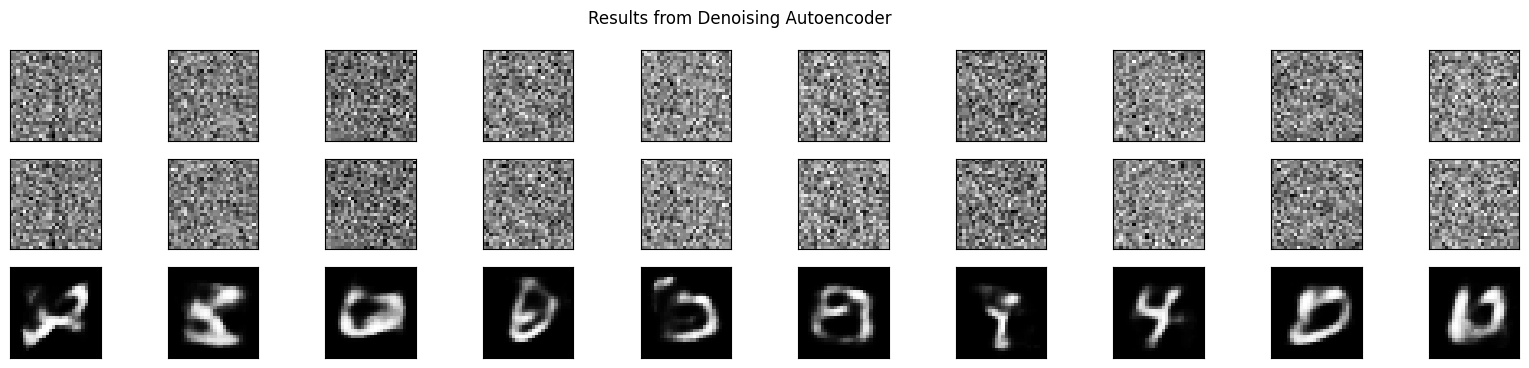

In [37]:
final_images_dae, reconstructions_dae = apply_gradient_ascent(dae, tf.reshape(random_noise_tensor, (-1, 784)), model_type='denoising_autoencoder')
display_images(random_noise_images, final_images_dae.numpy().reshape(-1, 28, 28, 1), reconstructions_dae.numpy().reshape(-1, 28, 28, 1), "Results from Denoising Autoencoder")

## Contractive autoencoder final results

[contractive_autoencoder] Iteration 2: Converged with Loss = 0.4109564423561096 and gradient norm = 0.017573293298482895


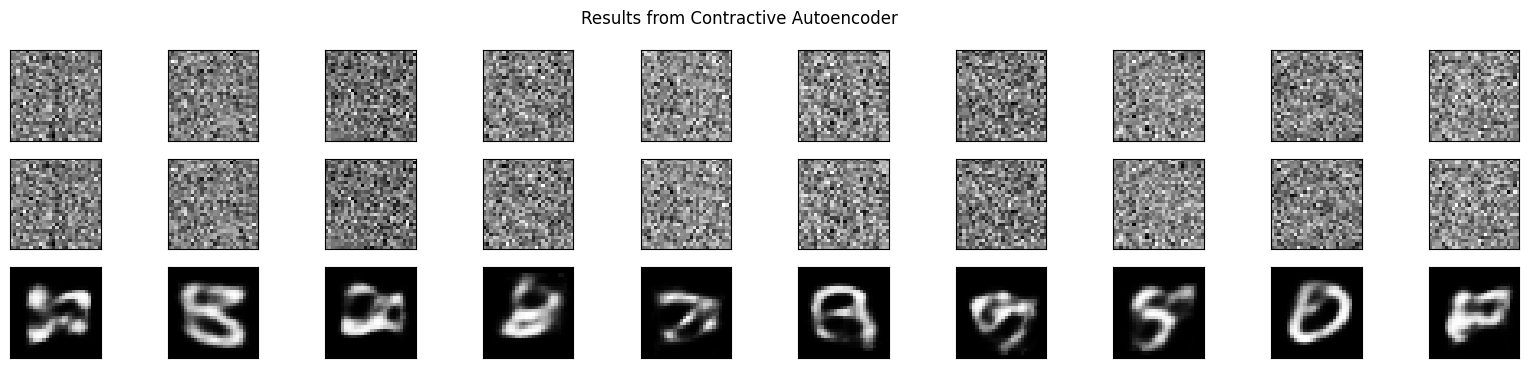

In [38]:
final_images_cae, reconstructions_cae = apply_gradient_ascent(cae, tf.reshape(random_noise_tensor, (-1, 784)), model_type='contractive_autoencoder')
display_images(random_noise_images, final_images_cae.numpy().reshape(-1, 28, 28, 1), reconstructions_cae.numpy().reshape(-1, 28, 28, 1), "Results from Contractive Autoencoder")

# Analysis


## Data loading and preparation

The MNIST dataset is loaded and preprocessed. The preprocessing includes normalization to scale pixel values between 0 and 1 and reshaping to fit the autoencoder input requirements.

### Noise addition

Functions are defined to generate random noise and to add this noise to the clean MNIST images. This simulates real-world scenarios where data may be corrupted by various factors.

## Autoencoder construction

### Denoising autoencoder

Comprises an encoder that compresses the input into a smaller, dense representation and a decoder that attempts to reconstruct the input from this compressed form. The model aims to clean the noisy images by learning to ignore the noise during training.

###Contractive autoencoder
Similar in structure to the DAE but includes a custom loss function. This function adds a contractive term to the standard reconstruction loss, which penalizes large weights to encourage robust feature learning.
### Training

Both autoencoders are trained using the noisy images as input and the clean images as targets. Early stopping is implemented to prevent overfitting.

### Gradient ascent

A method to iteratively enhance the image quality by adjusting the input image based on the gradient of the loss function with respect to the input. This method tests whether the autoencoders can refine random noise into something resembling the dataset’s manifold, i.e., digit-like structures.

 ### Experimentation and results Visualization

After training, the autoencoders are tested with both noisy MNIST  images to test their skills and entirely random noise images. The results are visualized in a series of plots that compare the original images, the added noise, and the reconstructions from each autoencoder.

 ## Result analisys

This experiment emphasizes comparing the effectiveness of the two autoencoders in handling noise and their ability to recover data characteristics from random noise inputs. The experiment with gradient ascent is particularly insightful as it explores whether the trained autoencoders can "imagine" digits from noise, essentially testing the limits of their generative capabilities.

The visualization of outputs plays a crucial role in interpreting the autoencoders' performance. It provides a qualitative assessment of how well each model reconstructs and denoises but also offers insights into the models' different learning and generalization behaviors.

## Denoising Autoencoder (DAE) Results Analysis


### Top Row
The top row illustrates the initial random noise images that are fed into the DAE. The patterns are uniformly noisy, lacking any discernible features or hints of the underlying MNIST digit forms.

### Bottom Row
The bottom row demonstrates the output from the Denoising Autoencoder after it has attempted to remove the noise and reconstruct the digits. The results vary; some digits like "0" and "4" are fairly well restored, showing clear and recognizable shapes. However, other digits retain some blurriness and residual noise, indicating that the DAE has limitations in handling cases with higher levels of distortion or more complex digit shapes.

## Contractive Autoencoder (CAE) Results Analysis

### Top Row

Commencing with an identical array of random noise inputs as the DAE, the CAE processes these images without preliminary distinctions in the visual noise pattern.

### Bottom Row
The output from the Contractive Autoencoder shown in the bottom row reveals a generally better performance in denoising compared to the DAE. The digits such as "8", "5", and "0" are notably sharper and more distinct, with less residual noise visible. The improvements suggest that the CAE may be more effective at preserving important features in the input data, possibly due to its mechanism of penalizing the sensitivity of the output to input variations, thus maintaining more of the structural integrity of the digits.


# Considerations

This experiment has been my favorite, largely because of the indistinguishable visual feedback provided by the transformations of random noise into recognizable digits. This clear visual distinction between the input noise and the output images allowed me to perform in-depth analyses and understand whether the models were functioning correctly. It provided concrete evidence of the model's capabilities and limitations in real-time, making the complexities of deep learning models more tangible and easier to grasp.